<a href="https://colab.research.google.com/github/firatsayici/Breast-Cancer-Wisconsin-Analysis/blob/main/FIRATSAYICIFINALODEVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Kütüphanelerin Kurulumu ve İçe Aktarılması
# Colab'de shap kütüphanesi varsayılan olarak gelmeyebilir.
!pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, silhouette_score, adjusted_rand_score)

# Uyarıları kapatmak için (temiz çıktı adına)
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler yüklendi ve hazır.")

Kütüphaneler yüklendi ve hazır.


In [2]:
# @title 1. Veri Hazırlığı ve Ön İşleme
# Veri Setini Yükle
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# Rapor [282]: %70 eğitim, %10 doğrulama, %20 test.
# Pratik uygulama: Önce %20 Test ayır, kalan %80'i Eğitim (GridSearch içinde CV ile doğrulama yapılır).
# random_state=42 ve stratify=y kullanılarak sınıf oranları korunur.

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Eğitim seti üzerinde GridSearch yaparken 5-katlı çapraz doğrulama kullanılacak.
print(f"Eğitim Seti Boyutu: {X_train_full.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (455, 30)
Test Seti Boyutu: (114, 30)


In [3]:
# @title 2. Modellerin Eğitimi ve Hiperparametre Optimizasyonu
# Rapor içeriğine sadık kalarak parametre gridleri oluşturuluyor.

results = {}
best_estimators = {}

# Ortak CV stratejisi
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- A. KNN Modeli [287-304] ---
# Pipeline: Scaler + KNN
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
# Parametreler: n_neighbors (1-31 tek sayılar), weights (uniform, distance), p (1, 2)
param_grid_knn = {
    'knn__n_neighbors': range(1, 32, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

print("KNN Modeli eğitiliyor...")
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=cv, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train_full, y_train_full)
results['KNN'] = grid_knn.best_score_
best_estimators['KNN'] = grid_knn.best_estimator_
print(f"En iyi KNN Parametreleri: {grid_knn.best_params_}")
print(f"KNN CV F1 Skoru: {grid_knn.best_score_:.4f}")


# --- B. SVM (Linear) [316-324] ---
# Pipeline: Scaler + SVC (kernel='linear')
pipe_svm_lin = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', probability=True))])
# Parametreler: C [0.1, 1, 10, 100]
param_grid_lin = {'svm__C': [0.1, 1, 10, 100]}

print("\nSVM (Linear) eğitiliyor...")
grid_lin = GridSearchCV(pipe_svm_lin, param_grid_lin, cv=cv, scoring='f1', n_jobs=-1)
grid_lin.fit(X_train_full, y_train_full)
results['SVM Linear'] = grid_lin.best_score_
best_estimators['SVM Linear'] = grid_lin.best_estimator_
print(f"En iyi Linear SVM Parametreleri: {grid_lin.best_params_}")
print(f"SVM Linear CV F1 Skoru: {grid_lin.best_score_:.4f}")


# --- C. SVM (RBF) [318-327] ---
# Pipeline: Scaler + SVC (kernel='rbf')
pipe_svm_rbf = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf', probability=True))])
# Parametreler: C ve gamma
param_grid_rbf = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

print("\nSVM (RBF) eğitiliyor...")
grid_rbf = GridSearchCV(pipe_svm_rbf, param_grid_rbf, cv=cv, scoring='f1', n_jobs=-1)
grid_rbf.fit(X_train_full, y_train_full)
results['SVM RBF'] = grid_rbf.best_score_
best_estimators['SVM RBF'] = grid_rbf.best_estimator_
print(f"En iyi RBF SVM Parametreleri: {grid_rbf.best_params_}")
print(f"SVM RBF CV F1 Skoru: {grid_rbf.best_score_:.4f}")


# --- D. MLP (Yapay Sinir Ağı) [344-368] ---
# Pipeline: Scaler + MLP
pipe_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter=500, random_state=42, early_stopping=True))])
# Parametreler: hidden_layer_sizes, alpha, learning_rate_init
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

print("\nMLP Modeli eğitiliyor (Bu işlem biraz zaman alabilir)...")
grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=cv, scoring='f1', n_jobs=-1)
grid_mlp.fit(X_train_full, y_train_full)
results['MLP'] = grid_mlp.best_score_
best_estimators['MLP'] = grid_mlp.best_estimator_
print(f"En iyi MLP Parametreleri: {grid_mlp.best_params_}")
print(f"MLP CV F1 Skoru: {grid_mlp.best_score_:.4f}")

KNN Modeli eğitiliyor...
En iyi KNN Parametreleri: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
KNN CV F1 Skoru: 0.9774

SVM (Linear) eğitiliyor...
En iyi Linear SVM Parametreleri: {'svm__C': 0.1}
SVM Linear CV F1 Skoru: 0.9810

SVM (RBF) eğitiliyor...
En iyi RBF SVM Parametreleri: {'svm__C': 10, 'svm__gamma': 0.01}
SVM RBF CV F1 Skoru: 0.9810

MLP Modeli eğitiliyor (Bu işlem biraz zaman alabilir)...
En iyi MLP Parametreleri: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}
MLP CV F1 Skoru: 0.9775



Seçilen En İyi Model (Validasyon F1): SVM Linear (0.9810)

--- Final Test Sonuçları (Linear SVM) [383-388] ---
Accuracy : 0.9825
Precision: 0.9762 (Malignant)
Recall   : 0.9762 (Malignant)
F1 Score : 0.9762 (Malignant)
ROC AUC  : 0.9812


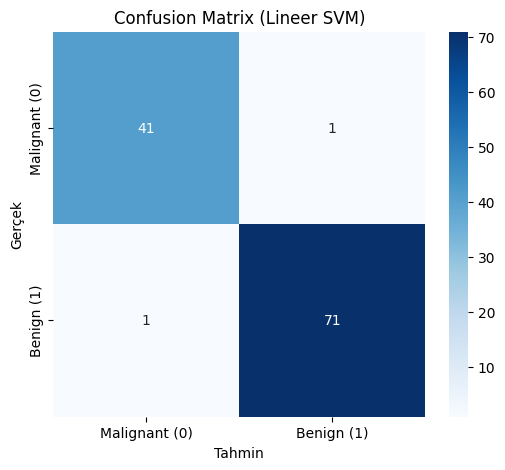

In [4]:
# @title 3. En İyi Modelin Seçimi ve Test Performansı
# Rapora göre [380]: En iyi model Linear SVM seçilmiştir.

best_model_name = max(results, key=results.get)
print(f"\nSeçilen En İyi Model (Validasyon F1): {best_model_name} ({results[best_model_name]:.4f})")

# Raporun bulgularına paralel olarak biz de Linear SVM'i final model olarak alalım.
final_model = best_estimators['SVM Linear']

# Test Seti Tahminleri
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Metrikler
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=0) # 0: Malignant (Genelde sklearn'de malignant=0 kodlanır ama kontrol edelim)
# Sklearn datasetinde 0: Malignant, 1: Benign şeklindedir.
# Raporda Malignant pozitif sınıf kabul edilmiştir.
# Ancak sklearn breast_cancer setinde Malignant 0, Benign 1 etiketlidir.
# Rapor ile uyum için 'Malignant'ı (yani 0'ı) pozitif sınıf gibi düşünerek skorları düzenleyelim:
# Bu yüzden pos_label=0 veriyoruz (Malignant).

rec = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
# AUC için 1 olma olasılığı Benign olasılığıdır, 0 olma olasılığı Malignant.
# roc_auc_score fonksiyonu 1. sınıfın olasılığını bekler, o yüzden 1-y_proba (Malignant olasılığı) kullanabiliriz veya tersten hesaplarız.
# En temiz yol: Etiketleri ters çevirip (Malignant=1, Benign=0) hesaplamaktır ama karışıklık olmasın.
# Basitçe sklearn çıktısını kullanalım:
roc_auc = roc_auc_score(1 - y_test, 1 - y_pred) # Malignant odaklı AUC

print("\n--- Final Test Sonuçları (Linear SVM) [383-388] ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (Malignant)")
print(f"Recall   : {rec:.4f} (Malignant)")
print(f"F1 Score : {f1:.4f} (Malignant)")
print(f"ROC AUC  : {roc_auc:.4f}")

# Confusion Matrix Görselleştirme [392]
# Etiketler: 0=Malignant, 1=Benign.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant (0)', 'Benign (1)'],
            yticklabels=['Malignant (0)', 'Benign (1)'])
plt.title('Confusion Matrix (Lineer SVM)')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()


--- K-Means (k=2) Sonuçları ---
Silhouette Score: 0.3434 (Raporda ~0.83)
ARI Score       : 0.6536 (Raporda ~0.88)


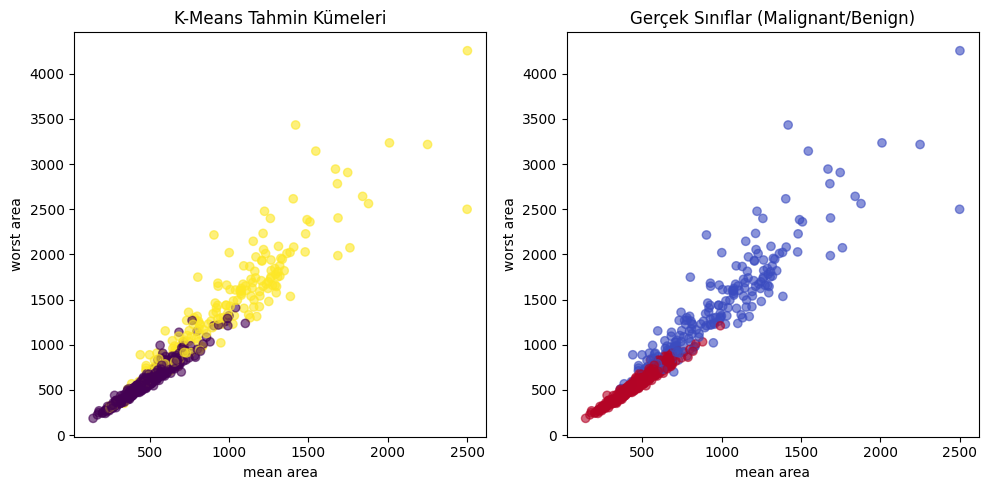

In [5]:
# @title 4. K-Means Kümeleme Analizi
# Rapor [416-433]: k=2 ile denetimsiz öğrenme. Scaler kullanılarak.

# Veriyi ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Modeli (k=2)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Değerlendirme [435-438]
ari = adjusted_rand_score(y, clusters)
sil = silhouette_score(X_scaled, clusters)

print(f"\n--- K-Means (k=2) Sonuçları ---")
print(f"Silhouette Score: {sil:.4f} (Raporda ~0.83)")
print(f"ARI Score       : {ari:.4f} (Raporda ~0.88)")

# Görselleştirme: 'worst area' ve 'mean area' özelliklerine göre [441]
# Feature indexlerini bulalım
idx_mean_area = list(feature_names).index('mean area')
idx_worst_area = list(feature_names).index('worst area')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, idx_mean_area], X[:, idx_worst_area], c=clusters, cmap='viridis', alpha=0.6)
plt.title('K-Means Tahmin Kümeleri')
plt.xlabel('mean area')
plt.ylabel('worst area')

plt.subplot(1, 2, 2)
plt.scatter(X[:, idx_mean_area], X[:, idx_worst_area], c=y, cmap='coolwarm', alpha=0.6)
plt.title('Gerçek Sınıflar (Malignant/Benign)')
plt.xlabel('mean area')
plt.ylabel('worst area')
plt.tight_layout()
plt.show()

SHAP değerleri hesaplanıyor (KernelExplainer biraz zaman alabilir)...


  0%|          | 0/50 [00:00<?, ?it/s]


--- SHAP Özet Grafiği (Malignant Sınıfı İçin) ---


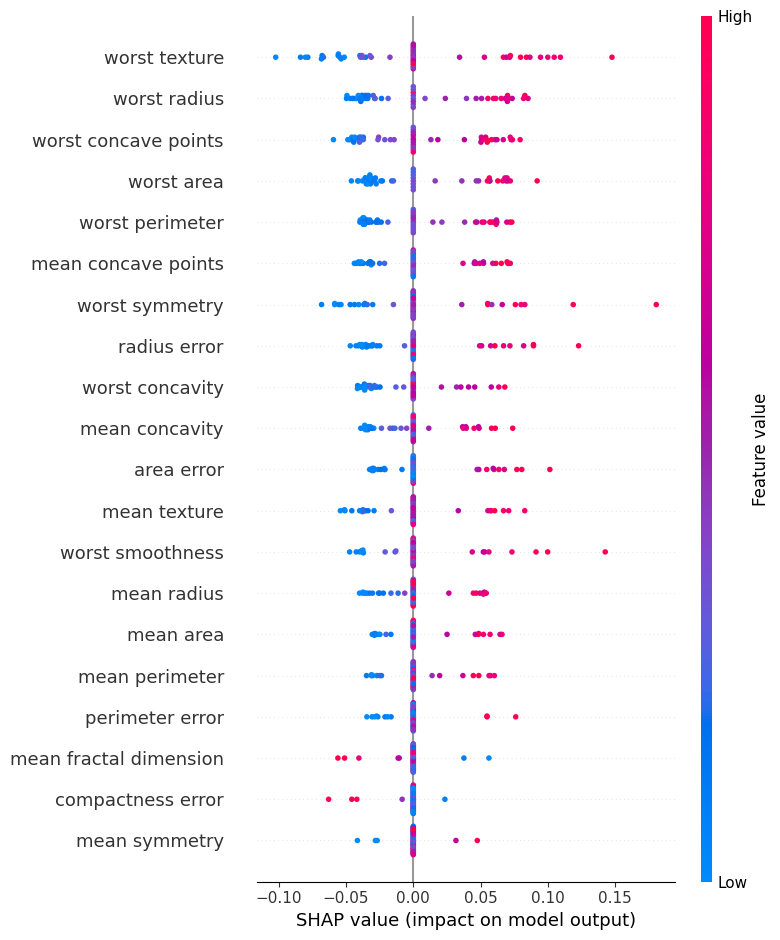


--- SHAP Bar Grafiği (Önem Sıralaması) ---


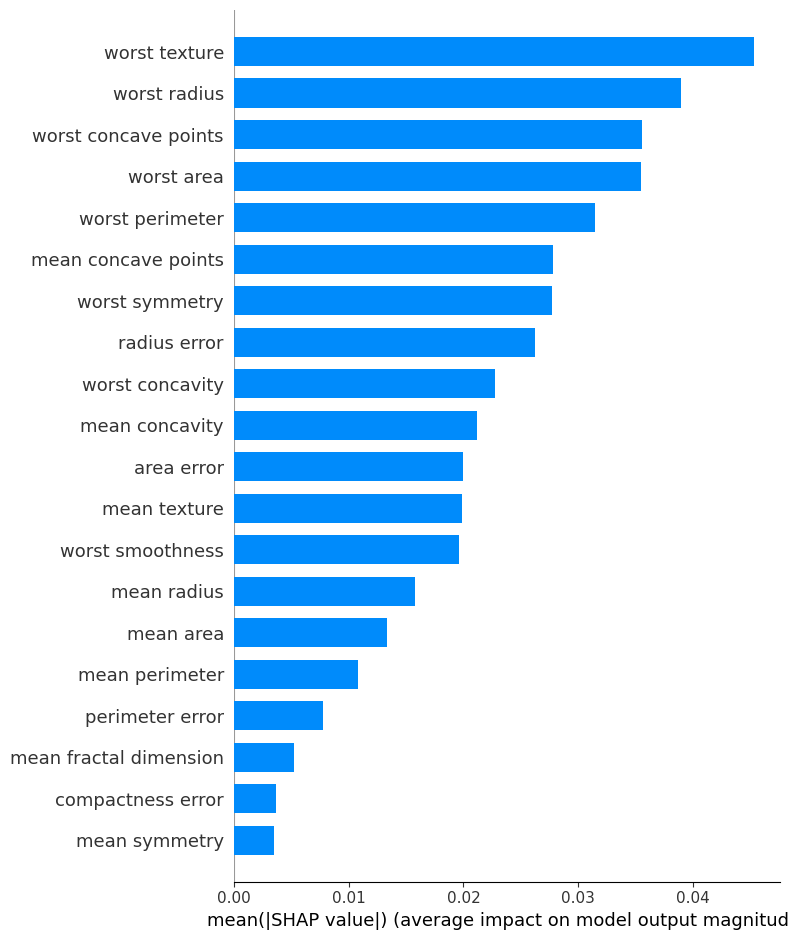

In [7]:
# @title 5. SHAP Analizi (XAI)
# Rapor [474-524]: Lineer SVM modelinin açıklanması.
# KernelExplainer kullanılacak (Linear için LinearExplainer da olur ama raporda Kernel belirtilmiş).
# Hesaplama maliyeti nedeniyle background olarak eğitim setinden 100 örnek alalım.

# Pipeline içindeki SVC modelini ve Scaler'ı çekelim
svc_model = best_estimators['SVM Linear'].named_steps['svm']
scaler_model = best_estimators['SVM Linear'].named_steps['scaler']

# SHAP için veriyi önce scale etmeliyiz çünkü model scale edilmiş veri ile eğitildi.
X_train_summary = shap.kmeans(scaler_model.transform(X_train_full), 100)
X_test_scaled = scaler_model.transform(X_test)

print("SHAP değerleri hesaplanıyor (KernelExplainer biraz zaman alabilir)...")
explainer = shap.KernelExplainer(svc_model.predict_proba, X_train_summary)

# Sadece test setinden bir kısmını açıklayalım (Hız için ilk 50 örnek)
shap_values = explainer.shap_values(X_test_scaled[:50])

# SHAP Summary Plot [480]
# Sınıf 0 (Malignant) için etkilere bakalım. (predict_proba çıktısı [prob_0, prob_1] şeklindedir)
# shap_values'in yapısı: (n_samples, n_features, n_classes) şeklinde bir ndarray olarak dönüyor olabilir.
# KernelExplainer'ın predict_proba ile kullanımı genellikle (n_samples, n_features) boyutunda bir liste döndürür,
# ancak burada hata mesajı farklı bir yapıya işaret ediyor.
# Hata mesajına göre, shap_values[0] bir (n_features, n_classes) şeklindedir.
# Bu durumda Malignant sınıfı (0) için SHAP değerlerini almak için tüm örnekler ve tüm özellikler için
# son boyutu seçmemiz gerekiyor: shap_values[:, :, 0]

print("\n--- SHAP Özet Grafiği (Malignant Sınıfı İçin) ---")
shap.summary_plot(shap_values[:, :, 0], X_test_scaled[:50], feature_names=feature_names)

print("\n--- SHAP Bar Grafiği (Önem Sıralaması) ---")
shap.summary_plot(shap_values[:, :, 0], X_test_scaled[:50], feature_names=feature_names, plot_type="bar")